# Assessment 3:

This notebook builds a prediction model that predicts whether or not a customer who is a target of a campaign is likely to purchase a Term deposit.

Ths notebook will illustrate the 16 phases of the AI lifecycle to build this predictor.

# Phase 1: Identify & Formulate the problem

The banks would like to predict if a customer being campaigned is likely to buy a Term deposit. They had previously run a capaign and collected data about that campaign.

The data collected in the previous campaign can be used to create a AI model that predicts which customers to taget in a new campaign.

As the output is a Yes or No prediction of whether they'll purchase or not, this is a Categorical Binary Prediction problem, with 2 classes - Yes or No.

# Phase 2: Review literature, ethics, pretrained models

Pretrained models are not available for this particular problem, hence will have to build a new one, based on existing AI python libraries.

A good model will benefit end customers and the bank as it will help target only customers who are likely to take it up, reducing costs.

There are no obvious risks to the customers that will be increased by the creation of this model. It will help the efficiency of the campaign.

# Phase 3: Data preparation

## Importing the necessary Python libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The following two commands ignore some warnings which are generally thrown due to version updates.
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Modelling utilities
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics 

# For Modelling 
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import neighbors
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Explainability and visualisation libraries
from xgboost import plot_tree
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns
# install shap explainability
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Read the data into a panda dataframe and view basic stats

In [2]:
data_url = 'https://raw.githubusercontent.com/hdushan/optus_u_ai_ml_assignment/main/bank-term-deposit.csv'
bank_dataset = pd.read_csv(data_url)
bank_dataset.head()
bank_dataset.info()
print(bank_dataset.shape)
bank_dataset.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# Phase 4: Data exploration

## Check for missing values

In [3]:
# trim away whitespace
bank_dataset = bank_dataset.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
# replace blanks with NaN
bank_dataset.replace('', np.NaN, inplace=True)
# print number of NaN's for each feature, to see what needs to be cleaned
print(bank_dataset.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [4]:
# No missing values/NaNs, so nothing to remove

## See if data is balanced or biased towards one outcome ('y' being the target variable)



In [5]:
print(bank_dataset['y'].value_counts())
print(bank_dataset['y'].value_counts(normalize=True))

no     36548
yes     4640
Name: y, dtype: int64
no     0.887346
yes    0.112654
Name: y, dtype: float64


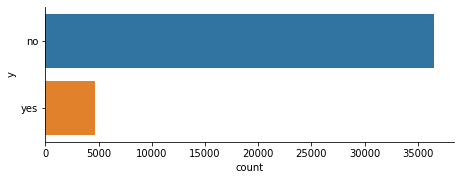

In [6]:
# Visualize the imbalance towards No in a plot
sns.catplot(y="y", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

## Use a heatmap to visualise the data and see pairwise corelation of the numerical features

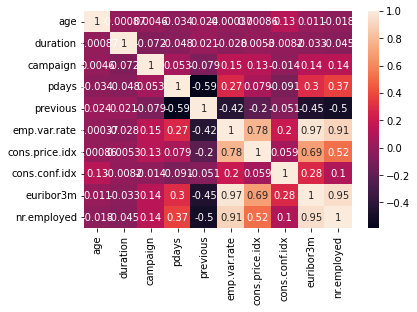

In [7]:
#Use a dataframe function to calculate pairwise correlation 
corr_matrix = bank_dataset.corr()

#and then use seaborn heatmap for viz
sns.heatmap(corr_matrix, annot=True)

# Phase 5: External/Strategic data aquisition

More data isnt available, from other sources, hence skipping this phase.

# Phase 6: Data Preprocessing

## Change the categorical values of the output variable to a boolean True/False value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

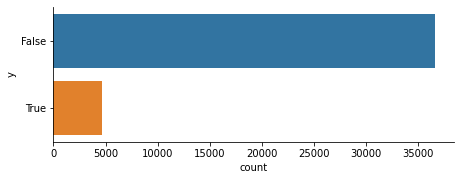

In [8]:
bank_dataset['y'].replace({'yes': True, 'no': False}, inplace=True)

# check to see the output variable and bias hasnt been messed up
bank_dataset.info()
sns.catplot(y="y", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

## Drop unwanted columns

In [9]:
# As mentioned here: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing ,
# duration: last contact duration, in seconds (numeric). Important note: this 
# attribute highly affects the output target (e.g., if duration=0 then y='no'). 
# Yet, the duration is not known before a call is performed. 
# Also, after the end of the call y is obviously known. 
# Thus, this input should only be included for benchmark purposes and 
# should be discarded if the intention is to have a realistic predictive model

# As per above, remove this 'duration' feature from the dataframe
bank_dataset = bank_dataset.drop(columns=['duration'])
bank_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

## Explore each feature and apply imputation where needed


In [10]:
# Based on the above output of the info command, the string features are:
# job
# marital
# education
# default
# housing
# loan
# contact
# month (ordinal)
# day_of_week (ordinal)
# poutcome

# print unique values of each of the above string features to see which ones have "unknown"s
print("job: ", bank_dataset.job.unique())
print("marital: ", bank_dataset.marital.unique())
print("education: ", bank_dataset.education.unique())
print("default: ", bank_dataset.default.unique())
print("housing: ", bank_dataset.housing.unique())
print("loan: ", bank_dataset.loan.unique())
print("contact: ", bank_dataset.contact.unique())
print("month: ", bank_dataset.month.unique())
print("day_of_week: ", bank_dataset.day_of_week.unique())
print("poutcome: ", bank_dataset.poutcome.unique())

job:  ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital:  ['married' 'single' 'divorced' 'unknown']
education:  ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default:  ['no' 'unknown' 'yes']
housing:  ['no' 'yes' 'unknown']
loan:  ['no' 'yes' 'unknown']
contact:  ['telephone' 'cellular']
month:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week:  ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome:  ['nonexistent' 'failure' 'success']


### "Unknown"s in Job feature

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

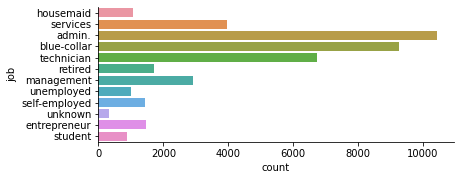

In [11]:
bank_dataset['job'].value_counts()
sns.catplot(y="job", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [12]:
# Replace the unknown job rows with the mode of this column
job_mode = bank_dataset['job'].mode()[0]
print('Mode of job: ', job_mode)
bank_dataset['job'] = bank_dataset['job'].replace({'unknown':job_mode})
bank_dataset['job'].value_counts()

Mode of job:  admin.


admin.           10752
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
Name: job, dtype: int64

### "Unknown"s in Marital feature

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

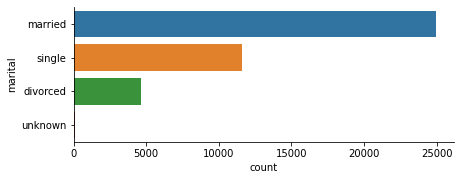

In [13]:
bank_dataset['marital'].value_counts()
sns.catplot(y="marital", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [14]:
# # Replace the unknown marital rows with the mode of this column
# marital_mode = bank_dataset['marital'].mode()[0]
# print('Mode of marital: ', marital_mode)
# bank_dataset['marital'] = bank_dataset['marital'].replace({'unknown':marital_mode})
# bank_dataset['marital'].value_counts()

# Remove the unknown marital rows as the percentage of data lost is very little
bank_dataset = bank_dataset[bank_dataset.marital != 'unknown']
bank_dataset['marital'].value_counts()

married     24928
single      11568
divorced     4612
Name: marital, dtype: int64

### "Unknown"s in Education feature

university.degree      12137
high.school             9501
basic.9y                6037
professional.course     5237
basic.4y                4170
basic.6y                2286
unknown                 1722
illiterate                18
Name: education, dtype: int64

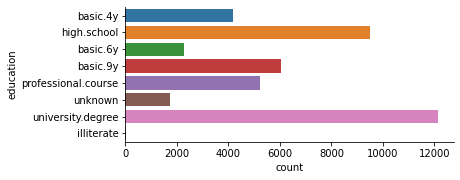

In [15]:
bank_dataset['education'].value_counts()
sns.catplot(y="education", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [16]:
# Replace unknown education with the mode of the column
education_mode = bank_dataset['education'].mode()[0]
print('Mode of education: ', education_mode)
bank_dataset['education'] = bank_dataset['education'].replace({'unknown':education_mode})
bank_dataset['education'].value_counts()

Mode of education:  university.degree


university.degree      13859
high.school             9501
basic.9y                6037
professional.course     5237
basic.4y                4170
basic.6y                2286
illiterate                18
Name: education, dtype: int64

### "Unknown"s in Default feature

no         32519
unknown     8586
yes            3
Name: default, dtype: int64

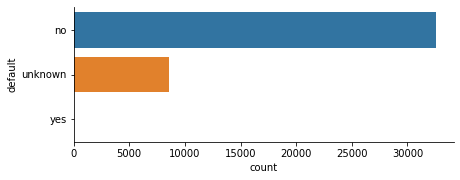

In [17]:
bank_dataset['default'].value_counts()
sns.catplot(y="default", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [18]:
# Replace unknown default with the mode of the column
default_mode = bank_dataset['default'].mode()[0]
print('Mode of default: ', default_mode)
bank_dataset['default'] = bank_dataset['default'].replace({'unknown':default_mode})
bank_dataset['default'].value_counts()

Mode of default:  no


no     41105
yes        3
Name: default, dtype: int64

### "Unknown"s in Housing feature

yes        21541
no         18578
unknown      989
Name: housing, dtype: int64

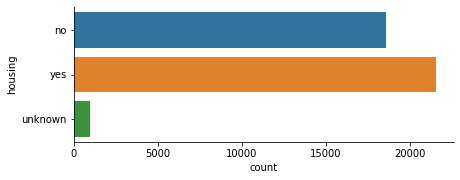

In [19]:
bank_dataset['housing'].value_counts()
sns.catplot(y="housing", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [20]:
# Replace unknown housing with the mode of the column
housing_mode = bank_dataset['housing'].mode()[0]
print('Mode of housing: ', housing_mode)
bank_dataset['housing'] = bank_dataset['housing'].replace({'unknown':housing_mode})
bank_dataset['housing'].value_counts()

Mode of housing:  yes


yes    22530
no     18578
Name: housing, dtype: int64

### "Unknown"s in Job feature

no         33883
yes         6236
unknown      989
Name: loan, dtype: int64

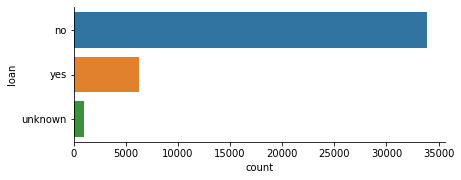

In [21]:
bank_dataset['loan'].value_counts()
sns.catplot(y="loan", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [22]:
# Replace unknown loan with the mode of the column
loan_mode = bank_dataset['loan'].mode()[0]
print('Mode of loan: ', loan_mode)
bank_dataset['loan'] = bank_dataset['loan'].replace({'unknown':loan_mode})
bank_dataset['loan'].value_counts()

Mode of loan:  no


no     34872
yes     6236
Name: loan, dtype: int64

### "Unknown"s in Poutcome feature

nonexistent    35501
failure         4239
success         1368
Name: poutcome, dtype: int64

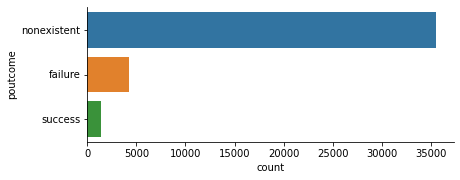

In [23]:
bank_dataset['poutcome'].value_counts()
sns.catplot(y="poutcome", kind="count", data=bank_dataset, height=2.6, aspect=2.5, orient='h')

In [24]:
# "nonexistant" seems legit, i'm assuming it means customer wasnt contacted prevoiusly.
# Leaving as is

### '999' in the pdays feature

In [25]:
print("pdays: ", bank_dataset.pdays.unique())
bank_dataset['pdays'].value_counts()

pdays:  [999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]


999    39598
3        439
6        410
4        117
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        27
1         26
15        24
14        20
8         18
0         15
16        10
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

In [26]:
# As 999 means Never contacted previously, its not really a "unknown"
# and therefore does not need to be imputed

## Explore Categorical features

In [27]:
def plot_categorical_features(features, title):
  fig, axs = plt.subplots(ncols=2,
                          nrows=int(len(features) / 2) + len(features) % 2)
  fig.set_size_inches(20, 10)

  row = col = 0

  for feature in features:
    plot_title = '{} - {}'.format(title, feature)
    sns.countplot(x=feature, hue="y", data=bank_dataset, ax=axs[row][col]).set_title(plot_title)

    if col == 1:
      col = 0
      row += 1
    else:
      col += 1

  plt.tight_layout()

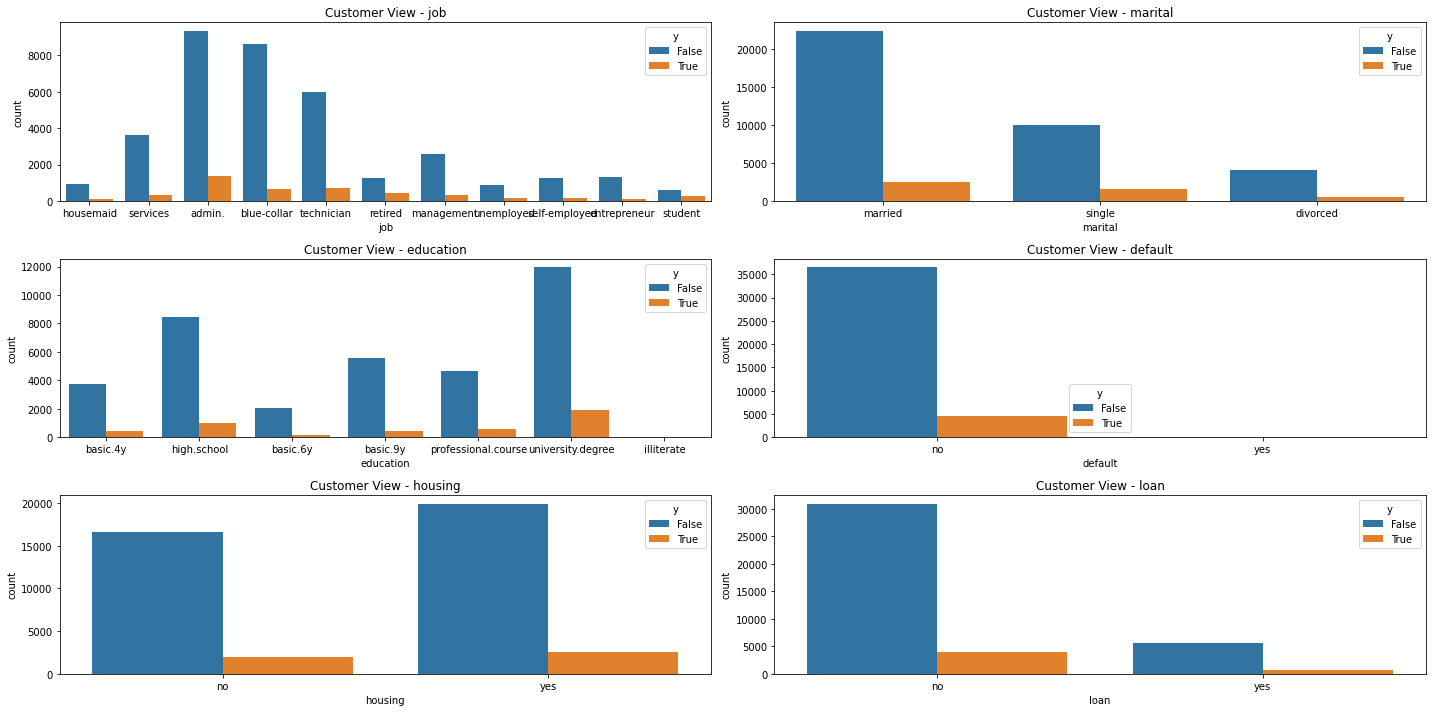

In [28]:
plot_categorical_features(['job', 'marital', 'education', 'default', 'housing', 'loan'], 'Customer View')



*   Divorced poeple seem proportionallly less likely to buy than singles and married people
*   Professional course educated people seem prportionally more inclined to buy than other education levels





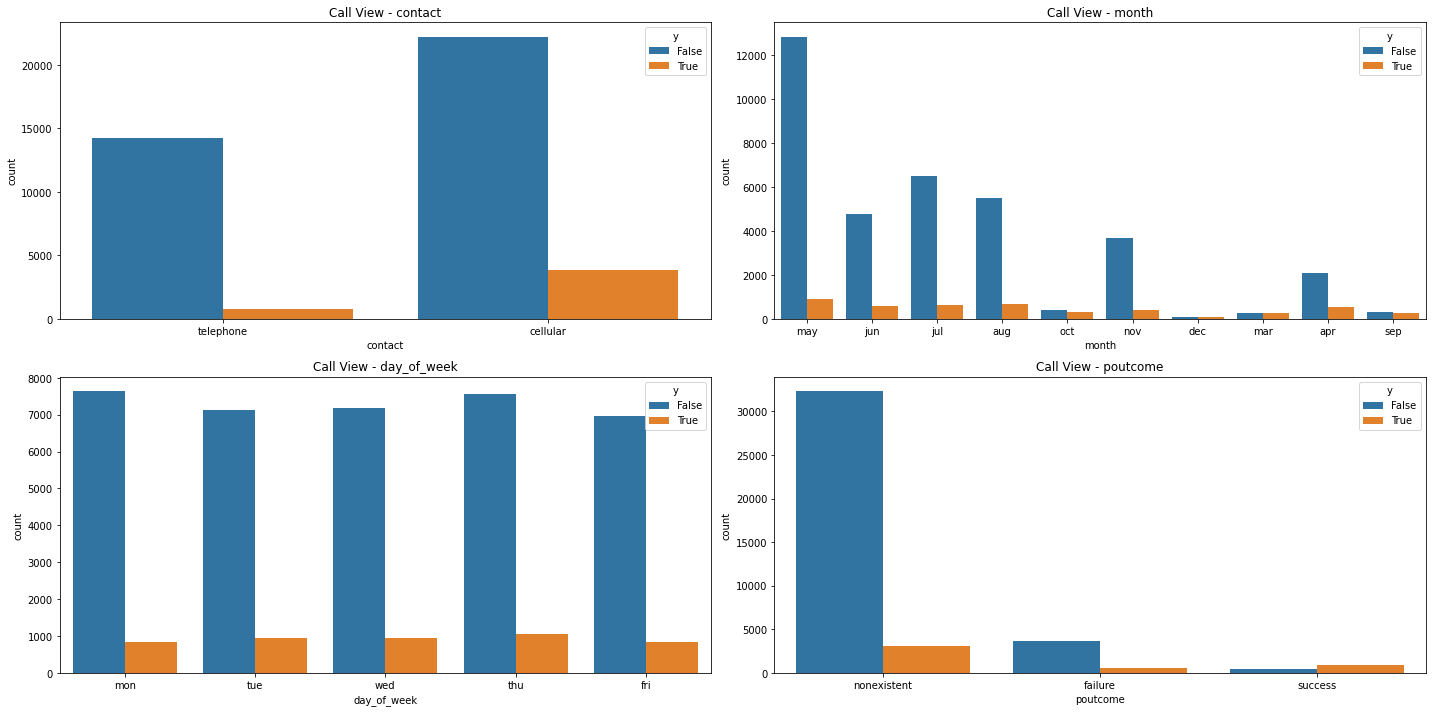

In [29]:
plot_categorical_features(['contact', 'month', 'day_of_week', 'poutcome'], 'Call View')

*   People contacted over telephone seem less likely to buy than people contacted over cellular
*   Proportionally, contacts in July, Aug, Oct, Apr & Sep are more likely to be successful
*   People who successful targets before are more likely to be successfull targets now too
*   The day of week has no impact on outcome

## Explore Numerical features

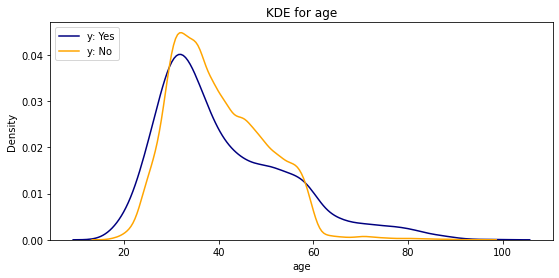

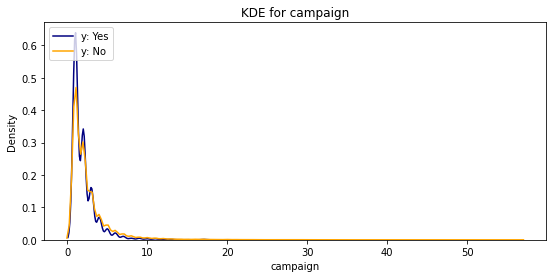

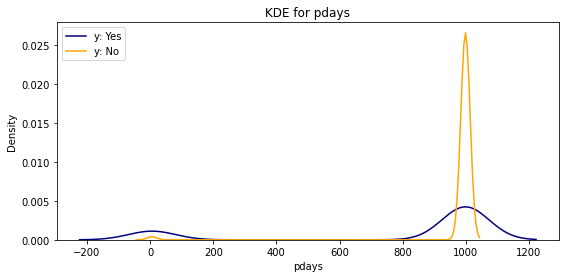

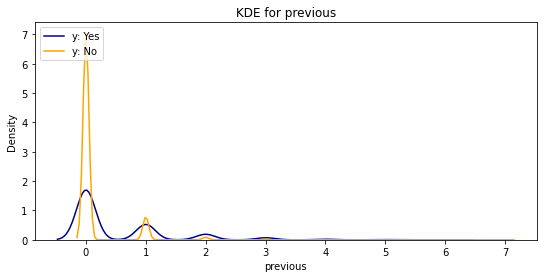

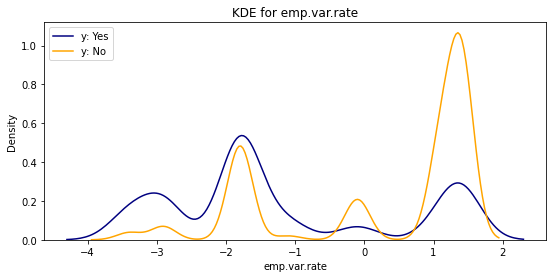

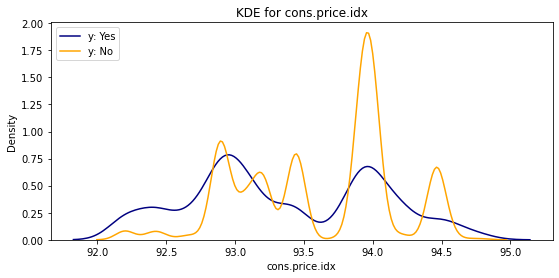

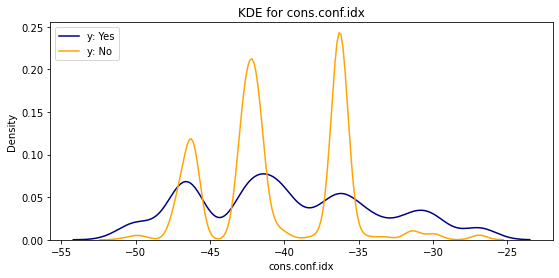

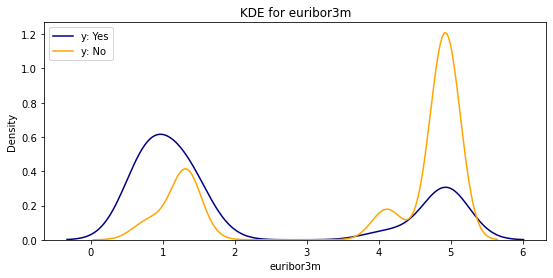

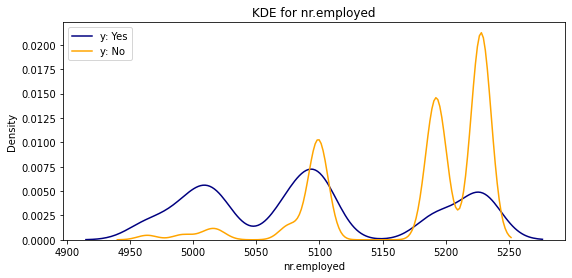

In [30]:
# here we create a function as we have to plot three graphs in the same format. 
def kdeplot(features):
    for feature in features:
      plt.figure(figsize=(9, 4))
      plt.title("KDE for {}".format(feature))
      sns.kdeplot(bank_dataset[bank_dataset['y'] == 1][feature], color= 'navy', label= 'y: Yes')
      sns.kdeplot(bank_dataset[bank_dataset['y'] == 0][feature], color= 'orange', label= 'y: No')
      plt.legend(loc="upper left")

columns = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
kdeplot(columns)



*   Age has no significant impact on outcome

*   Low cons.price.idx has a higher proportion of successful outcome that when the index is high




## Use one hot encoding to encode all string features

In [31]:
# feature: job

# Prepend column name prior to encoding
bank_dataset['job'] = 'job_' + bank_dataset['job'].astype(str)
# one hot encoding
one_hot_job = pd.get_dummies(bank_dataset['job'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_job)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,56,job_housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,0,1,0,0,0,0,0,0,0
1,57,job_services,married,high.school,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,1,0,0,0
2,37,job_services,married,high.school,no,yes,no,telephone,may,mon,...,0,0,0,0,0,0,1,0,0,0
3,40,job_admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,0,0
4,56,job_services,married,high.school,no,no,yes,telephone,may,mon,...,0,0,0,0,0,0,1,0,0,0


In [32]:
# feature: marital

# Prepend column name prior to encoding
bank_dataset['marital'] = 'marital_' + bank_dataset['marital'].astype(str)
# one hot encoding
one_hot_marital = pd.get_dummies(bank_dataset['marital'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_marital)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single
0,56,job_housemaid,marital_married,basic.4y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,1,0
1,57,job_services,marital_married,high.school,no,no,no,telephone,may,mon,...,0,0,0,1,0,0,0,0,1,0
2,37,job_services,marital_married,high.school,no,yes,no,telephone,may,mon,...,0,0,0,1,0,0,0,0,1,0
3,40,job_admin.,marital_married,basic.6y,no,no,no,telephone,may,mon,...,0,0,0,0,0,0,0,0,1,0
4,56,job_services,marital_married,high.school,no,no,yes,telephone,may,mon,...,0,0,0,1,0,0,0,0,1,0


In [33]:
# feature: education

# Prepend column name prior to encoding
bank_dataset['education'] = 'education_' + bank_dataset['education'].astype(str)
# one hot encoding
one_hot_education = pd.get_dummies(bank_dataset['education'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_education)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree
0,56,job_housemaid,marital_married,education_basic.4y,no,no,no,telephone,may,mon,...,0,1,0,1,0,0,0,0,0,0
1,57,job_services,marital_married,education_high.school,no,no,no,telephone,may,mon,...,0,1,0,0,0,0,1,0,0,0
2,37,job_services,marital_married,education_high.school,no,yes,no,telephone,may,mon,...,0,1,0,0,0,0,1,0,0,0
3,40,job_admin.,marital_married,education_basic.6y,no,no,no,telephone,may,mon,...,0,1,0,0,1,0,0,0,0,0
4,56,job_services,marital_married,education_high.school,no,no,yes,telephone,may,mon,...,0,1,0,0,0,0,1,0,0,0


In [34]:
# feature: default

# Prepend column name prior to encoding
bank_dataset['default'] = 'default_' + bank_dataset['default'].astype(str)
# one hot encoding
one_hot_default = pd.get_dummies(bank_dataset['default'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_default)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,no,no,telephone,may,mon,...,0,1,0,0,0,0,0,0,1,0
1,57,job_services,marital_married,education_high.school,default_no,no,no,telephone,may,mon,...,0,0,0,0,1,0,0,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,yes,no,telephone,may,mon,...,0,0,0,0,1,0,0,0,1,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,no,no,telephone,may,mon,...,0,0,1,0,0,0,0,0,1,0
4,56,job_services,marital_married,education_high.school,default_no,no,yes,telephone,may,mon,...,0,0,0,0,1,0,0,0,1,0


In [35]:
# feature: housing

# Prepend column name prior to encoding
bank_dataset['housing'] = 'housing_' + bank_dataset['housing'].astype(str)
# one hot encoding
one_hot_housing = pd.get_dummies(bank_dataset['housing'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_housing)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,no,telephone,may,mon,...,0,0,0,0,0,0,1,0,1,0
1,57,job_services,marital_married,education_high.school,default_no,housing_no,no,telephone,may,mon,...,0,0,1,0,0,0,1,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,no,telephone,may,mon,...,0,0,1,0,0,0,1,0,0,1
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,no,telephone,may,mon,...,1,0,0,0,0,0,1,0,1,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,yes,telephone,may,mon,...,0,0,1,0,0,0,1,0,1,0


In [36]:
# feature: loan

# Prepend column name prior to encoding
bank_dataset['loan'] = 'loan_' + bank_dataset['loan'].astype(str)
# one hot encoding
one_hot_loan = pd.get_dummies(bank_dataset['loan'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_loan)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,telephone,may,mon,...,0,0,0,0,1,0,1,0,1,0
1,57,job_services,marital_married,education_high.school,default_no,housing_no,loan_no,telephone,may,mon,...,1,0,0,0,1,0,1,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,telephone,may,mon,...,1,0,0,0,1,0,0,1,1,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,telephone,may,mon,...,0,0,0,0,1,0,1,0,1,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,telephone,may,mon,...,1,0,0,0,1,0,1,0,0,1


In [37]:
# feature: contact

# Prepend column name prior to encoding
bank_dataset['contact'] = 'contact_' + bank_dataset['contact'].astype(str)
# one hot encoding
one_hot_contact = pd.get_dummies(bank_dataset['contact'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_contact)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,contact_telephone,may,mon,...,0,0,1,0,1,0,1,0,0,1
1,57,job_services,marital_married,education_high.school,default_no,housing_no,loan_no,contact_telephone,may,mon,...,0,0,1,0,1,0,1,0,0,1
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,contact_telephone,may,mon,...,0,0,1,0,0,1,1,0,0,1
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,contact_telephone,may,mon,...,0,0,1,0,1,0,1,0,0,1
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,contact_telephone,may,mon,...,0,0,1,0,1,0,0,1,0,1


In [38]:
# feature: month

# Prepend column name prior to encoding
bank_dataset['month'] = 'month_' + bank_dataset['month'].astype(str)
# one hot encoding
one_hot_month = pd.get_dummies(bank_dataset['month'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_month)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,contact_telephone,month_may,mon,...,0,0,0,0,0,0,1,0,0,0
1,57,job_services,marital_married,education_high.school,default_no,housing_no,loan_no,contact_telephone,month_may,mon,...,0,0,0,0,0,0,1,0,0,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,contact_telephone,month_may,mon,...,0,0,0,0,0,0,1,0,0,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,contact_telephone,month_may,mon,...,0,0,0,0,0,0,1,0,0,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,contact_telephone,month_may,mon,...,0,0,0,0,0,0,1,0,0,0


In [39]:
# feature: day_of_week

# Prepend column name prior to encoding
bank_dataset['day_of_week'] = 'day_of_week' + bank_dataset['day_of_week'].astype(str)
# one hot encoding
one_hot_day_of_week = pd.get_dummies(bank_dataset['day_of_week'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_day_of_week)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_mar,month_may,month_nov,month_oct,month_sep,day_of_weekfri,day_of_weekmon,day_of_weekthu,day_of_weektue,day_of_weekwed
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,1,0,0,0,0,1,0,0,0
1,57,job_services,marital_married,education_high.school,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,1,0,0,0,0,1,0,0,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,1,0,0,0,0,1,0,0,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,1,0,0,0,0,1,0,0,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,contact_telephone,month_may,day_of_weekmon,...,0,1,0,0,0,0,1,0,0,0


In [40]:
# feature: poutcome

# Prepend column name prior to encoding
bank_dataset['poutcome'] = 'poutcome_' + bank_dataset['poutcome'].astype(str)
# one hot encoding
one_hot_poutcome = pd.get_dummies(bank_dataset['poutcome'])
#append as a new column 
bank_dataset = bank_dataset.join(one_hot_poutcome)

bank_dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,month_oct,month_sep,day_of_weekfri,day_of_weekmon,day_of_weekthu,day_of_weektue,day_of_weekwed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,job_housemaid,marital_married,education_basic.4y,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,0,0,1,0,0,0,0,1,0
1,57,job_services,marital_married,education_high.school,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,0,0,1,0,0,0,0,1,0
2,37,job_services,marital_married,education_high.school,default_no,housing_yes,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,0,0,1,0,0,0,0,1,0
3,40,job_admin.,marital_married,education_basic.6y,default_no,housing_no,loan_no,contact_telephone,month_may,day_of_weekmon,...,0,0,0,1,0,0,0,0,1,0
4,56,job_services,marital_married,education_high.school,default_no,housing_no,loan_yes,contact_telephone,month_may,day_of_weekmon,...,0,0,0,1,0,0,0,0,1,0


In [41]:
#To avoid multicollinearity, we must drop one of the new columns created during one hot encoding
bank_dataset = bank_dataset.drop(columns=['job', 'marital', 'education', 
                                          'default', 'housing', 'loan', 
                                          'contact', 'month', 'day_of_week', 
                                          'poutcome'])

bank_dataset.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_oct,month_sep,day_of_weekfri,day_of_weekmon,day_of_weekthu,day_of_weektue,day_of_weekwed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,0,0,0,1,0,0,0,0,1,0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,0,0,0,1,0,0,0,0,1,0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,0,0,0,1,0,0,0,0,1,0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,0,0,0,1,0,0,0,0,1,0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,False,...,0,0,0,1,0,0,0,0,1,0


# Phase 7: Data Augmentation

For this problem, as the data is heavily skewed towards a No, a combination of oversampling (to increase percentage of Yes's) and undersampling (to reduce the percentage of No's) could be used to create a more balanced dataset.

In [42]:
# Separate input variables (X) from the target (y)
X, y = bank_dataset.drop(['y'], axis=1, errors='ignore'), bank_dataset['y']

In [43]:
# Use oversampler to make Yes's be 20 percent of the data
# and undersampling to reduce the No's, to make the Yes's to be 30% of the data.

oversample = RandomOverSampler(sampling_strategy=0.2)
undersample = RandomUnderSampler(sampling_strategy=0.3)

# resampling X, y
X_oversample, y_oversample = oversample.fit_resample(X, y)
X_undersample, y_undersample = undersample.fit_resample(X_oversample, y_oversample)
X_augmented, y_augmented = X_undersample, y_undersample
print('Before:\n', Counter(y))
print('After oversampling:\n', Counter(y_oversample))
print('After undersampling:\n', Counter(y_augmented))

Before:
 Counter({False: 36480, True: 4628})
After oversampling:
 Counter({False: 36480, True: 7296})
After undersampling:
 Counter({False: 24320, True: 7296})


# Phase 8 & 9 & 10: Prototype the model, develop benchmark, build several models

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_augmented,y_augmented,test_size = 0.30, random_state = 40)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (22131, 56) (22131,)
Test (9485, 56) (9485,)


In [45]:
#Logistic regression 
hrLogReg = LogisticRegression()
#fit the model on the training data
hrLogReg.fit(X_train, y_train)

LogisticRegression()

In [46]:
#Decision tree 
hrDecisionTree = tree.DecisionTreeClassifier()
hrDecisionTree.fit(X_train,y_train)

DecisionTreeClassifier()

In [47]:
# K-nearest neighbour 
hrKNN = neighbors.KNeighborsClassifier()
hrKNN.fit(X_train,y_train)

KNeighborsClassifier()

In [48]:
# XGBoost 
hrXGB = xgb.XGBClassifier(max_depth=4)
hrXGB.fit(X_train,y_train)

XGBClassifier(max_depth=4)

In [49]:
# Neural network - Multi-layer Perceptron
hrMLP = MLPClassifier()
hrMLP.fit(X_train,y_train)

MLPClassifier()

In [50]:
# Fit RandomForest Classifier
hrRFC = RandomForestClassifier()
hrRFC.fit(X_train, y_train)

RandomForestClassifier()

# Phase 11: Validate all the models

In [51]:
classifiers = [ hrMLP, hrXGB, hrKNN, hrDecisionTree, hrLogReg, hrRFC]
evalTable = PrettyTable(['Name', 'Accuracy', 'F1-score', 'ROC AUC score', 'AP score'])
for i in classifiers:
  # Predict the class
  y_predict = i.predict(X_test)
  # Predict probabilities and retrieve just the probabilities for the positive class
  y_prob = i.predict_proba(X_test)[:, 1]
  evalTable.add_row( [ type(i).__name__, (round(i.score(X_test, y_test),3)), 
                      (round(metrics.f1_score(y_test, y_predict),3)), 
                      (round(metrics.roc_auc_score(y_test, y_prob),3)), 
                      (round(metrics.average_precision_score(y_test, y_prob),3)),] )

print(evalTable)

+------------------------+----------+----------+---------------+----------+
|          Name          | Accuracy | F1-score | ROC AUC score | AP score |
+------------------------+----------+----------+---------------+----------+
|     MLPClassifier      |  0.811   |  0.399   |     0.787     |   0.61   |
|     XGBClassifier      |  0.834   |  0.577   |     0.814     |  0.654   |
|  KNeighborsClassifier  |  0.815   |  0.572   |     0.807     |  0.556   |
| DecisionTreeClassifier |  0.826   |  0.658   |     0.797     |  0.509   |
|   LogisticRegression   |  0.819   |  0.472   |     0.761     |  0.599   |
| RandomForestClassifier |   0.88   |  0.735   |     0.882     |  0.785   |
+------------------------+----------+----------+---------------+----------+


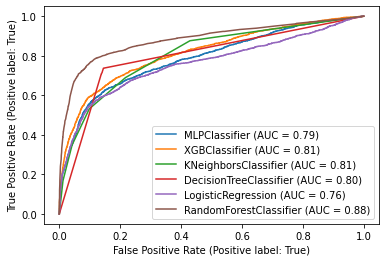

In [52]:
# Plot the ROC curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_roc_curve(i, X_test, y_test, ax=all_axes)

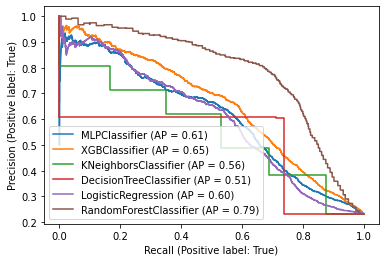

In [53]:
# Plot the precision-recall curves
all_axes = plt.gca()
for i in classifiers:
    metrics.plot_precision_recall_curve(i, X_test, y_test, ax=all_axes)



---
# Based on the above, the model with the *highest ROC AUC score* is the **RandomForestClassifier**, with a score of ***0.88***
---



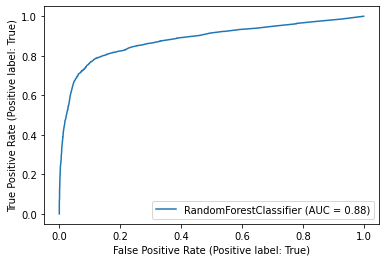

In [58]:
# Show ROC curve for this model
metrics.plot_roc_curve(hrRFC, X_test, y_test, ax=plt.gca())

# Phase 13: Develop and improve model explainability

<Figure size 720x864 with 0 Axes>

Text(0.5, 1.0, 'Feature importance')

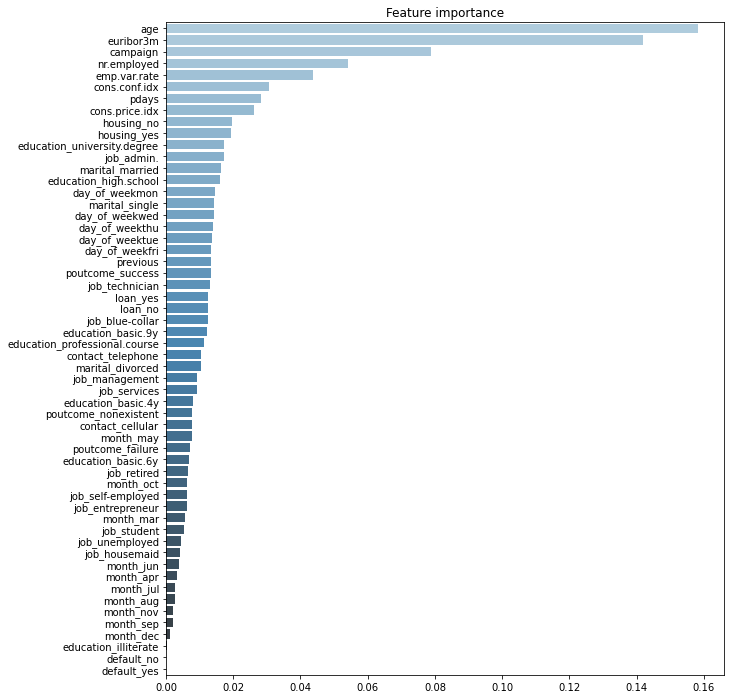

In [59]:
# Plot features importances
imp = pd.Series(data=hrRFC.feature_importances_, index=X_augmented.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

Sumary plot showing the direction of influence of each feature on the target variable

In [ ]:
import shap
shap.initjs()

In [ ]:
shapExplainerXGB = shap.TreeExplainer(hrXGB)
shap_values_xgb = shapExplainerXGB.shap_values(X_train)
shap.summary_plot(shap_values_xgb, X_train)

In [ ]:
# shapExplainer = shap.TreeExplainer(hrRFC)
# shap_values = shapExplainer.shap_values(X_train)
# shap.summary_plot(shap_values[1], X_train)